# Session 2 - Random Forest Training

This is an introductory notebook to familiarize yourself with training and evaluation techniques for Machine Learning (ML). For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument  and a Random Forest algorithm to perform water classification. This same workflow can be adapted to other applications and by using other algorithms.

The intent of this notebook is three-fold. First we will walk through the fundamentals of a Random Forest algorithm. Next,we will perform some training using the Random Forest algorithm. Finally, we will perform inference using the Random Forest algorith, and will include some metrics to analyze its performance. The entire work is done using the Python programming language and based on a dataset uploaded to Hugging Face.

Author: Caleb S. Spradlin, Jordan A. Caraballo-Vega
Release Date: 2023.04.08
Last Modified: 2023.04.08

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.


In [1]:
!wget https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py

--2023-04-12 06:54:07--  https://raw.githubusercontent.com/NASAARSET/ARSET_ML_Fundamentals/main/src/folium_helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6189 (6.0K) [text/plain]
Saving to: ‘folium_helper.py’

folium_helper.py    100%[===================>]   6.04K  --.-KB/s    in 0s      

2023-04-12 06:54:07 (54.7 MB/s) - ‘folium_helper.py’ saved [6189/6189]



In [2]:
!pip install datasets rasterio pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 1.4 MB/s eta 0:00:00


In [3]:
import os
import sys
import csv
import time
import glob
import joblib
import datasets
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

from huggingface_hub import snapshot_download

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal
import folium
from folium import plugins
import folium_helper

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables
In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [4]:
# directory where we will output figures
FIGURE_OUTPUT_DIR = 'output'

# directory where we will output raster
RASTER_OUTPUT_DIR = 'output'

# directory where we will output our models
MODEL_OUTPUT_DIR = 'models'

# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# ratio of the dataset split for testing
TEST_RATIO = 0.2

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our models and visualizations.

In [5]:
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(FIGURE_OUTPUT_DIR, exist_ok=True)

Output any columns we will need to drop for training



In [6]:
colsToDrop

['x_offset', 'y_offset', 'year', 'julian_day']

In [7]:
colsToDropTraining

['x_offset',
 'y_offset',
 'year',
 'julian_day',
 'x_offset',
 'y_offset',
 'year',
 'julian_day',
 'tileID']

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:

- Read in data to a Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [8]:
%%time
train_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='train'))
test_dataset = pd.DataFrame(datasets.load_dataset(DATASET_URL, split='test'))

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/nasa-cisto-data-science-group___csv/nasa-cisto-data-science-group--modis-lake-powell-toy-dataset-b44b60340eda6604/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


CPU times: user 948 ms, sys: 57.3 ms, total: 1.01 s
Wall time: 2.02 s


After we download our dataset, we proceed to split it into training and test set. Note how the water column is set as the y feature and is dropped from the X features.

In [9]:
X_train, y_train = train_dataset.drop(['water'], axis=1), train_dataset['water']
X_test, y_test = test_dataset.drop(['water'], axis=1), test_dataset['water']
X_train.shape, X_test.shape

((800, 10), (200, 10))

For this exercise we have downloaded our data directly from Hugging Face where we already had made the split between training and test. However, how would you do it if your dataset was not splitted already?

One way to achieve this is by using the train_test_split function from sckit-learn to directly split these features into train and test set. Here we take an example 800 rows dataset and split it into training and test sets:

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dataset.drop(['water'], axis='columns'),
    train_dataset['water'],
    random_state=RANDOM_STATE,
    train_size=0.80,
)

Lets look at the distribution of our classes after the split:

In [11]:
y_train.value_counts(), y_test.value_counts()

(1    322
 0    318
 Name: water, dtype: int64,
 1    83
 0    77
 Name: water, dtype: int64)

The distribution of the training and test features are close to 50% water and 50% not-water on each. scikit-learn train_test_split() provides another parameter where the stratification of the test dataset is forced to match the one of the training dataset.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    train_dataset.drop(['water'], axis='columns'),
    train_dataset['water'],
    random_state=RANDOM_STATE,
    train_size=0.70,
    stratify=train_dataset['water']  # TODO: double check what this means
)

In [13]:
y_train.value_counts(), y_test.value_counts()

(1    284
 0    276
 Name: water, dtype: int64,
 1    121
 0    119
 Name: water, dtype: int64)

Note how we now have a larger number of test samples, and smaller number of training samples. Which one to choose will depend on the problem you have in hand.

## 4. Training Preparation

Once we have our training and test data ready, we proceed to prepare for training our model. One technique often used to better validate the robustness of a machine learning model is K-fold cross validation.

Cross-validation is a statistical method used to estimate the skill of machine learning models. When using k-fold, the dataset is split into ‘k’ number of subsets, k-1 subsets then are used to train the model and the last subset is kept as a validation set to test the model. Then the score of the model on each fold is averaged to evaluate the performance of the model.

sckit-learn provides a useful feature to quickly setup these experiments. A K of 10 has been described by literature as the most effective value to decrease variance and nominally test performance. In this example, we will use a value of K = 5 for time purposes.

In [14]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [15]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


Like we did in the first exercise of this Session, we can look at some of the features of the data before proceeding to train.

In [16]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,560.0,1204.898214,1258.518881,15.0,234.50,899.5,1882.00,9045.0
sur_refl_b02_1,560.0,1568.241071,1526.138500,1.0,165.25,1429.0,2662.25,8795.0
sur_refl_b03_1,560.0,747.867857,982.646604,-100.0,288.00,555.0,860.00,8844.0
sur_refl_b04_1,560.0,1028.750000,1042.995031,6.0,404.75,813.0,1320.00,9056.0
sur_refl_b05_1,560.0,1947.705357,1440.492111,-92.0,557.75,1802.5,3178.50,6382.0
sur_refl_b06_1,560.0,1912.583929,1519.511426,51.0,514.25,1459.5,3196.00,6610.0
sur_refl_b07_1,560.0,1570.451786,1373.370210,5.0,320.75,1192.5,2657.75,6128.0
ndvi,560.0,65.605357,2546.290592,-9493.0,-1630.50,712.5,1721.75,8587.0
ndwi1,560.0,-2338.526786,3451.658914,-9862.0,-4629.25,-1547.5,-715.75,8823.0
ndwi2,560.0,-1005.717857,3793.531161,-9692.0,-2856.00,-695.0,798.75,9453.0


We can also use thresholding methods based on our physical knowledge to extract interesting features of outliers that we might want to visualize later when evaluating the model.

In [17]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [18]:
output_interesting_idx(X_train, 'ndvi', 1000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
770,1798,2465,755,1229,3201,3397,2891,1564,-1589,-795
167,1895,2769,850,1372,3679,3569,2852,1873,-1262,-147
371,1737,2362,558,911,3049,3448,3067,1524,-1869,-1298
357,1828,2525,972,1412,3092,3299,2829,1601,-1328,-567
173,1987,2906,1063,1638,3462,3842,3351,1878,-1387,-711
...,...,...,...,...,...,...,...,...,...,...
187,2511,3490,857,1419,4525,4825,4148,1631,-1605,-861
449,940,2034,405,669,2291,2114,1533,3678,-192,1404
794,2214,3229,877,1384,3575,3278,2754,1864,-75,793
76,2099,3118,552,1313,3676,3994,3080,1953,-1231,61


## 5. Model definition and training

In this section we will define our model and train it using our dataset. The hyperparameters listed below are the default from the scikit-learn library, but these are usually very similar across other programming languages. Some of the most useful parameters to know about from the Random Forest are:
- n_estimators: number of trees in the forest
- max_features: max number of features considered for splitting a node
- max_depth: max number of levels in each decision tree
- min_samples_split: min number of data points placed in a node before the node is split
- min_samples_leaf: min number of data points allowed in a leaf node
- bootstrap: method for sampling data points (with or without replacement)

In [19]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

Here we define the classifier by including the hyperparameters we defined above.

In [20]:
classifier = skRF(**hyperparameters)

## 5.1 k-Fold fitting

Then we can proceed to train our model using the k-Fold approach. We perform K iterations, and by the end of the iterations we select the best performing model, and calculate the average score across all of them.

In [21]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}'.format(score))
    scores.append(score)
    del test_predictions, score

Train [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255
 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 

Here we can calculate the average score, and the score of the best model.

In [22]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.9928571428571429
Best accuracy score: 1.0


## 5.2 Regular fitting

We can also train our model without doing any k-Fold cross-validation. We can simply define our classifier, and perform the fit operation directly on the training dataset.

In [23]:
classifier = skRF(**hyperparameters)

In [24]:
%%time
classifier.fit(X_train, y_train)

CPU times: user 1.39 s, sys: 48.4 ms, total: 1.44 s
Wall time: 1.77 s


RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)

Then we can simply compute the score from the model output.

In [25]:
score = classifier.score(X_test, y_test)
print('Average accuracy score: {}'.format(score))

Average accuracy score: 0.9875


## 6. Model testing and training/testing data validation

Once we have trained our model we can proceed to use the best model and perform testing and validation using our dataset.

### 6.1 Get model metrics

We can calculate accuracy metrics from our model using the test dataset, but we can also output prediction probabilities to understand the drivers behind the model performance.

In [26]:
classifier = bestModel

In [27]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.992

Note how easy it is to perform predictions once we have datasets in dataframe format.

In [28]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

Here we can take the prediction probabilities straight out of the model so we can visualize them. These are important since they tell use the confidence of our model when perform the classification.

In [29]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

### 6.1.1 Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

Text(0.5, 1.0, 'Distribution of the probability of predicted values')

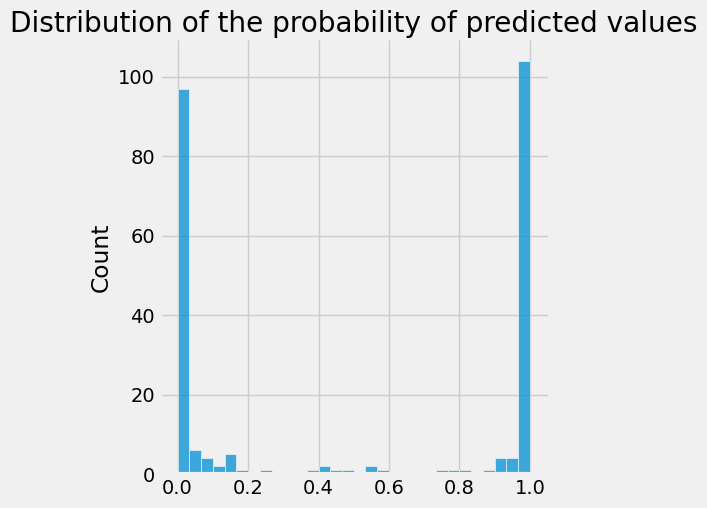

In [30]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

In [31]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

## 6.2 Additional Metrics 

We can compute additional metrics to understand model performance related to producer and user accuracy.

In [32]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       119
           1       1.00      0.98      0.99       121

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240

Test Recall
-------------------------------------------------------
1.0
Confusion Matrix
-------------------------------------------------------
[[119   0]
 [  2 119]]


We can also look at Receiver Operating Characteristic (ROC) plots to understand the performance of the model across all samples between True Positive and False Positive rates.

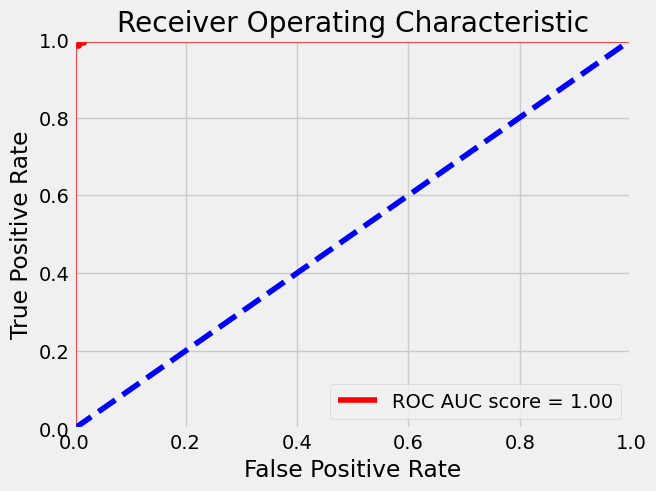

In [33]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 6.3 Permutation Importance

Another important metric to understand model performance is to evaluate permutation importance, particularly focused on the importance of each feature in the training and inference of the model.

In [34]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 9.56 s, sys: 782 ms, total: 10.3 s
Wall time: 14.8 s


Note how the sur_refl_b02_1 band was the variable of most importance during the training and inference of the model.

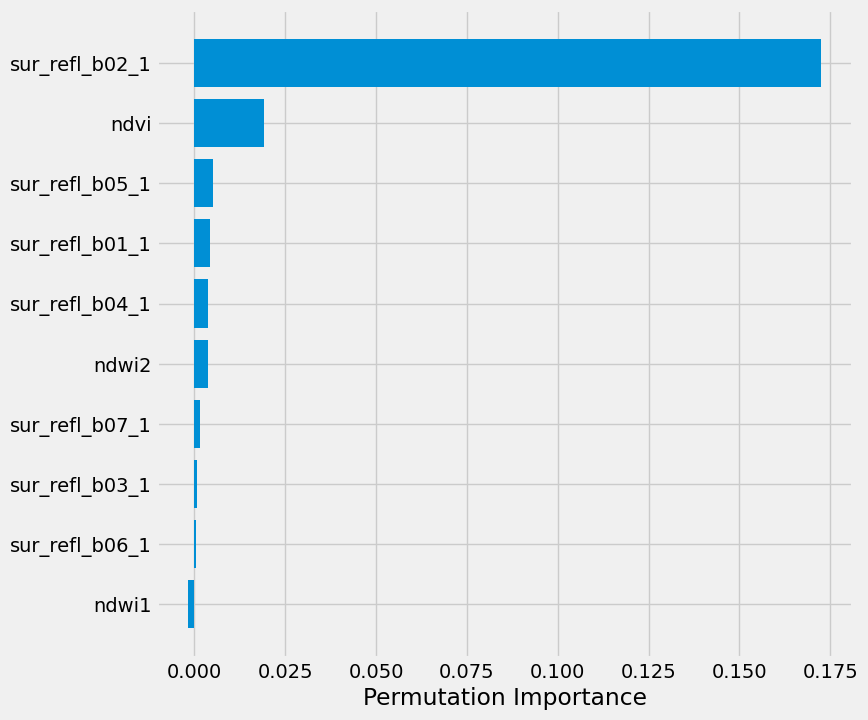

In [35]:
png_save_path = 'mw_{}_{}_rf_{}_permutation_importance.png'.format(
    score,
    hyperparameters['n_estimators'],
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

Garbage collection

In [36]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## 7. Save the model for future use

We can then save our model for future use so we can apply it or share it elsewhere. The only prerequisite would be for the input dataset to be in the same format as the input training data.

In [37]:
model_save_path = 'mw_{}_{}_{}_2.0.0_tuned_{}.sav'.format(score,
                                                             hyperparameters['n_estimators'],
                                                             'cpu',
                                                             datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: models/mw_0.992_400_cpu_2.0.0_tuned_2023_04_12_06_55.sav
RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)


['models/mw_0.992_400_cpu_2.0.0_tuned_2023_04_12_06_55.sav']

## 8. Raster Inference

## 8.1 Data download

Here we can proceed to perform inference using raster objects. The first step is to download some imagery to test with.

In [38]:
powell_dataset = snapshot_download(repo_id=DATASET_URL, allow_patterns="*.tif", repo_type='dataset')

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Then we can select all individual band TIF images and stack them to form the raster needed as input to the model. Note that you can skip this step if you already have your raster that includes all bands.

In [39]:
fileList = sorted([file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'sur_refl' in file])

Then we can perform some feature engineering on the fly to add some additional column features such as NDVI, NDWI1, and NDWI2.

In [40]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

We end up with a raster M x N x B, where B is the number of column features that will be included in the model input for inference.

In [41]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 456 ms, sys: 46.1 ms, total: 502 ms
Wall time: 955 ms


### 8.2 Data preparation

Here we convert our raster array into dataframe format to serve as input to the model.

In [42]:
raster_dataframe = pd.DataFrame(im, columns=v_names, dtype=np.float32)
raster_dataframe

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,1547.0,2461.0,857.0,1256.0,2684.0,2730.0,2222.0,2280.0,-518.0,510.0
1,1474.0,2377.0,857.0,1256.0,2684.0,2730.0,2222.0,2344.0,-691.0,337.0
2,1474.0,2377.0,846.0,1230.0,2630.0,2613.0,2098.0,2344.0,-472.0,623.0
3,1494.0,2461.0,846.0,1230.0,2630.0,2613.0,2098.0,2445.0,-299.0,796.0
4,1494.0,2461.0,846.0,1230.0,2630.0,2613.0,2098.0,2445.0,-299.0,796.0
...,...,...,...,...,...,...,...,...,...,...
1689995,2211.0,2826.0,1080.0,1796.0,3650.0,4266.0,3862.0,1220.0,-2030.0,-1549.0
1689996,2209.0,2801.0,1028.0,1791.0,3633.0,4223.0,3863.0,1181.0,-2024.0,-1593.0
1689997,2358.0,2979.0,1028.0,1791.0,3633.0,4223.0,3863.0,1163.0,-1727.0,-1292.0
1689998,2425.0,3069.0,1117.0,1876.0,3747.0,4345.0,3919.0,1172.0,-1721.0,-1216.0


In [43]:
def predictRaster(dataframe, colsToDrop=None):
    """
    Function given a raster in the form of a 
    GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = dataframe.drop(columns=colsToDrop) if colsToDrop else dataframe
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs

Once we have our features in the correct format, we can proceed to perform the inference using the model we previously saved.

In [44]:
%%time
predictedRaster, predictedProbaRaster = predictRaster(raster_dataframe)

Making predictions from raster
CPU times: user 1min 28s, sys: 332 ms, total: 1min 29s
Wall time: 59.6 s


### 8.3 Reshape the unravelled matrix back to the 4800x4800 raster shape

Here we reshape the raster back into its original shape for further visualization.

In [45]:
raster_shape = (1300, 1300)
predictedRasterNdArray = np.asarray(predictedRaster)
predictedRasterMatrix = predictedRasterNdArray.reshape(raster_shape)
predictedRasterMatrix.shape

(1300, 1300)

## 9. Postprocessing

Oftentimes we need to postprocess our output before reaching its final version. There are many postprocessing techniques out there and these will be dependent on your dataset.

### 9.1 Import the QA Mask and the Water Mask for the h09v05 TILE

For this particular problem, we will simply apply MODIS QA maks to our output raster as a postprocessing step.

In [46]:
qa = [file for file in glob.glob(os.path.join(powell_dataset, 'IL.*.Powell.*.tif')) if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### 9.2 Mask out results if QA Mask says pixel is "bad"

Mask out water mask if QA Mask says pixel is "bad".

In [47]:
raster_qad = np.where(qaMask == 0, predictedRasterMatrix, 255)

We we can plot a view of our water mask prediction.

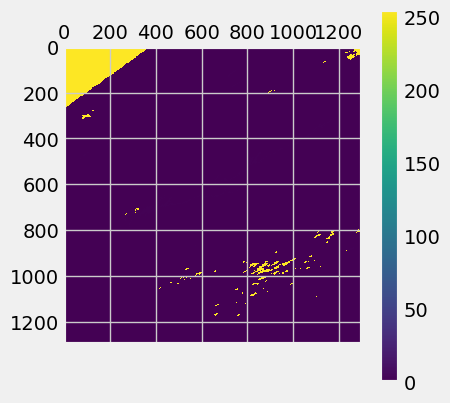

In [48]:
plt.matshow(raster_qad)
plt.colorbar()

### 9.3 Output predicted raster to GeoTiff

We can then output our raster array into a GeoTiff file for further analysis. We can produce Cloud Optimized GeoTIFF (COG) files in this step by simply change the 'GTiff' driver to 'COG'.

In [49]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

predictedPath = 'PowellPredictedWaterMask.tif'

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(raster_qad)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## 10. Visualize your output

We can then proceed to visualize the output of our model in an interactive map. But first, we need to fix the projection in order to properly display the map using the interactive visualization package called folium.

In [50]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


From there we can define a basemap and the region of interest for our map to initially start.

In [51]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


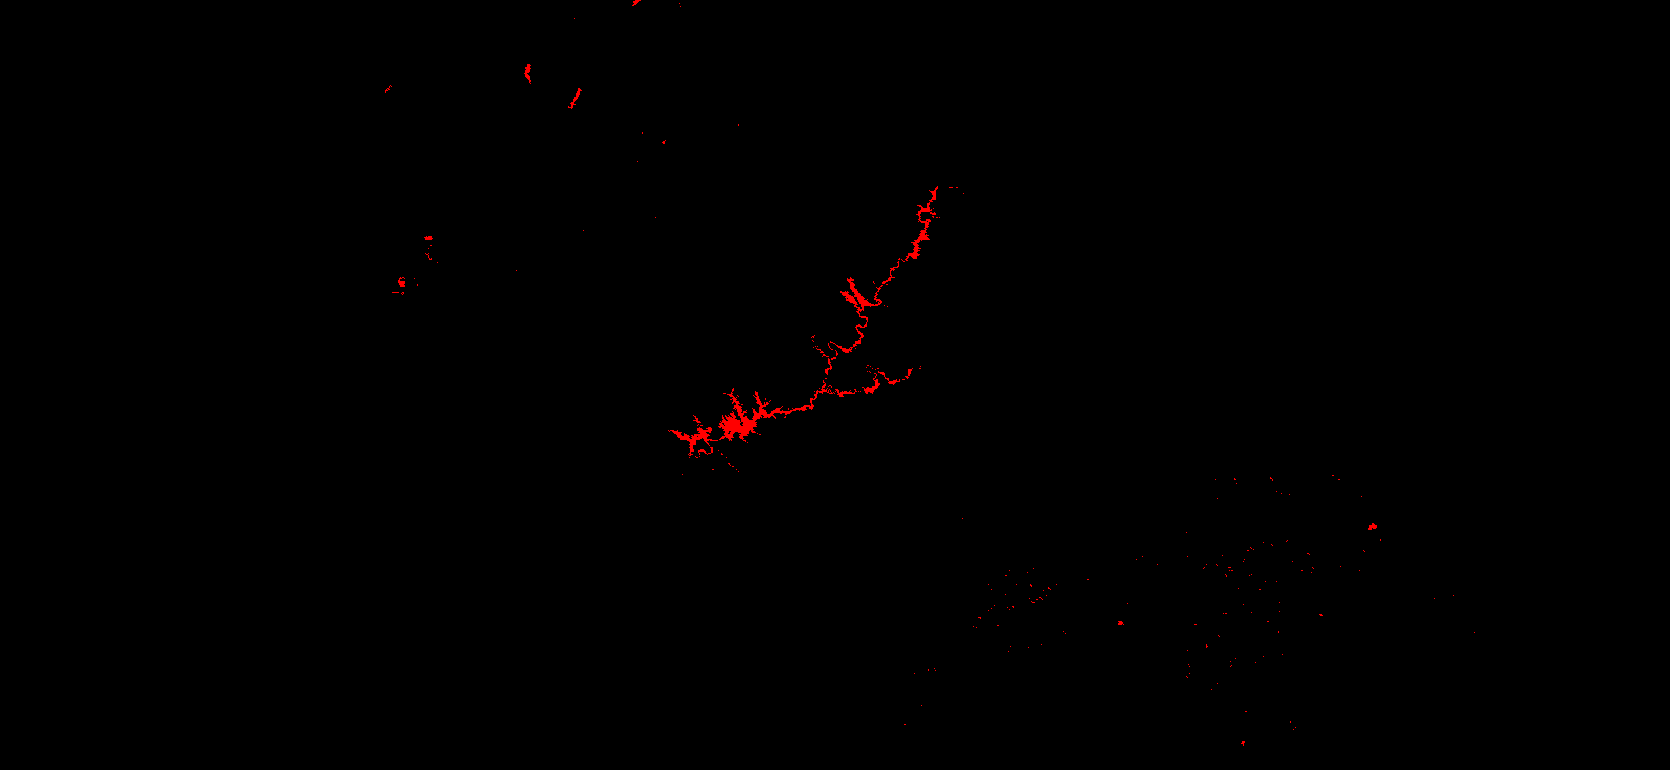

In [52]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification RF predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())

## Closing Thoughts

We have:

- Downloaded a MODIS based dataset for training and testing
- Performed additional EDA on the provided dataset
- Trained and performed inference of a Random Forest model
- Created interactive visualizations by prediction both tabular and raster datasets
- Provided a base for model explainability which will be discussed in our next session